In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
sns.set()


from itertools import product
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from scipy.optimize import minimize

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import r2_score, mean_absolute_error

%matplotlib inline

In [ ]:
data = pd.read_csv("israt/Water_Spring_Lupa.csv",index_col=['Date'],parse_dates=['Date'])
data.head()

In [ ]:
data.describe()

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4199 entries, 2009-01-01 to 2020-06-30
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Rainfall_Terni  4199 non-null   float64
 1   Flow_Rate_Lupa  3817 non-null   float64
dtypes: float64(2)
memory usage: 98.4 KB


In [8]:
data.isnull().sum()

Rainfall_Terni      0
Flow_Rate_Lupa    382
dtype: int64

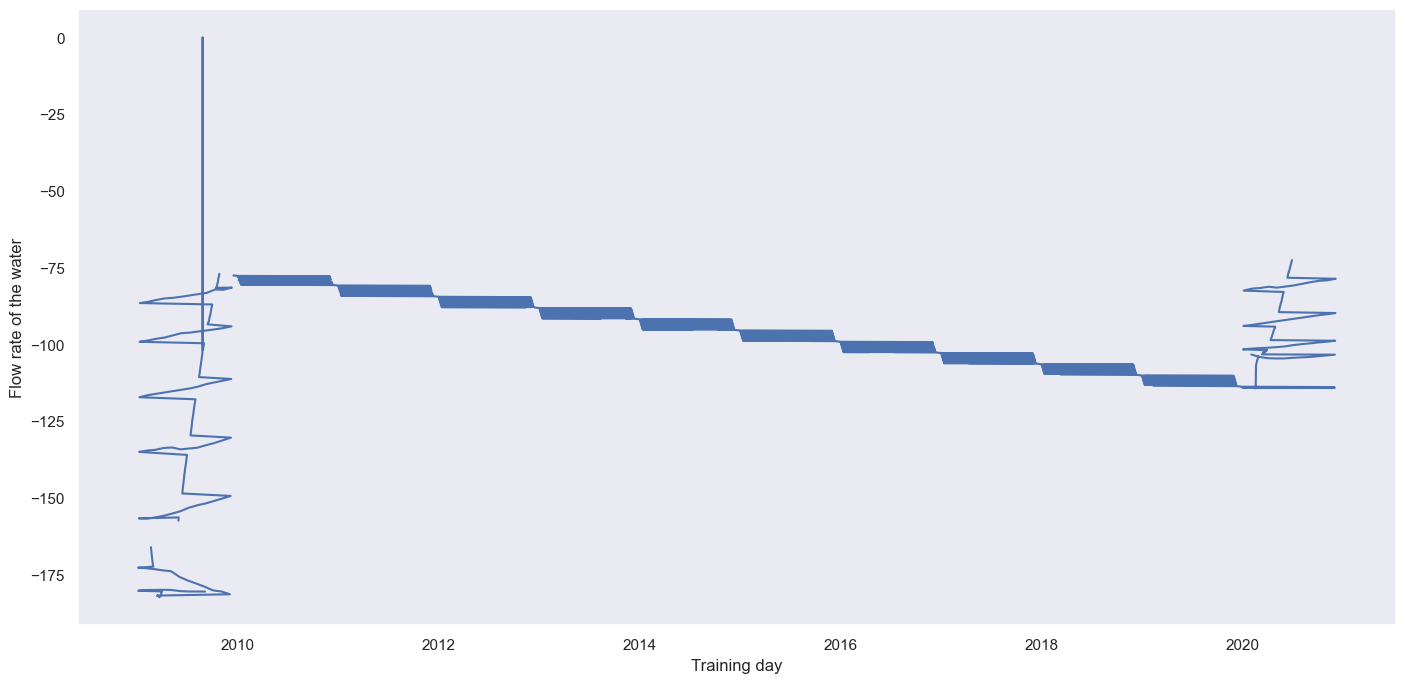

In [9]:
plt.figure(figsize=(17,8))
plt.plot(data.Flow_Rate_Lupa)
plt.xlabel("Training day")
plt.ylabel("Flow rate of the water")
plt.grid(False)
plt.show()

In [10]:
# MOVING_AVERAGE--

def moving_avg_plot(attribute,window):
    plt.figure(figsize=(17,8))
    plt.plot(attribute[window:], label="Actual")
    rolling_mean=attribute.rolling(window=window).mean()
    plt.plot(rolling_mean,'r', label="Rolling mean average")
    
    plt.grid(True)

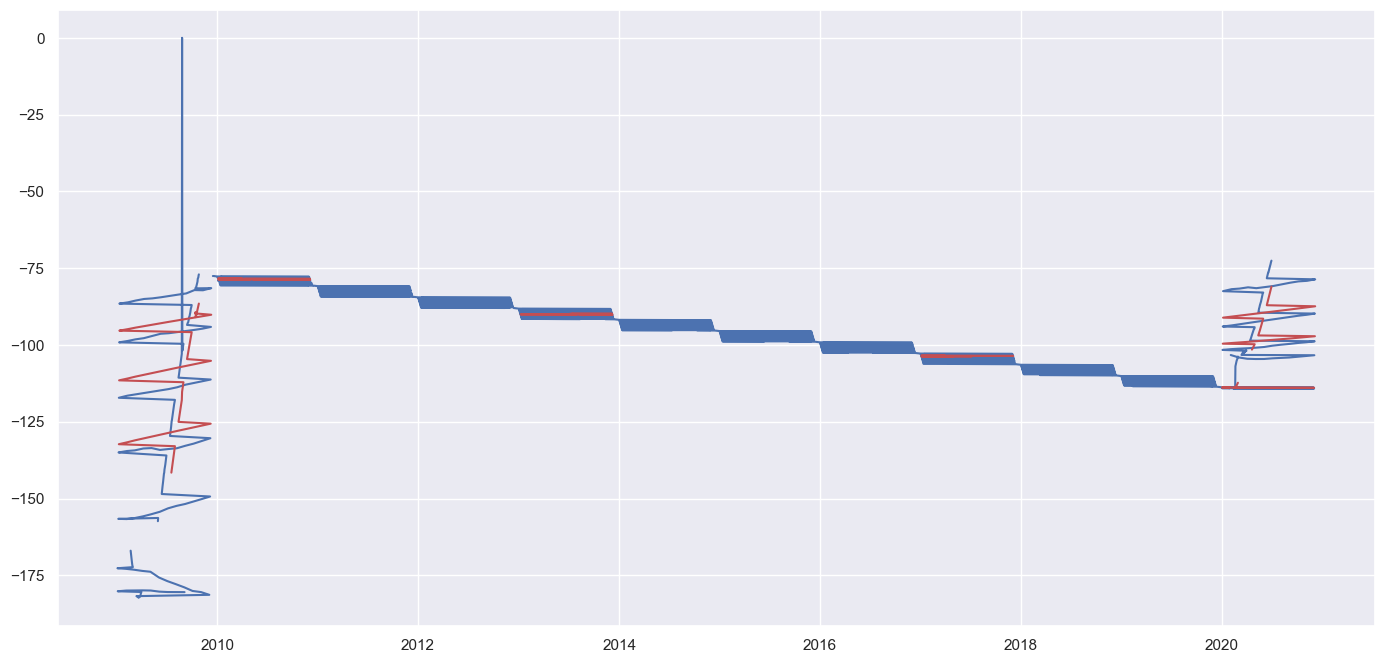

In [23]:
moving_avg_plot(data.Flow_Rate_Lupa, 50)

In [24]:
#Exponential Smoothing--

def exponential_smoothing(column,alpha):
    result=[column[0]]
    
    for n in range(1, len(column)):
        old=alpha*column[n]+(1-alpha)*result[n-1]
        result.append(old)
        
    return result

In [25]:
def exponential_smoothing_plot(column,alpha):
    plt.figure(figsize=(17,8))
    for a in alpha:
        plt.plot(exponential_smoothing(column,a), label=f"Alpha{a}")
        
    plt.plot(column.values,"c",label="Actual")
    plt.legend(loc="best")
    plt.grid(True)

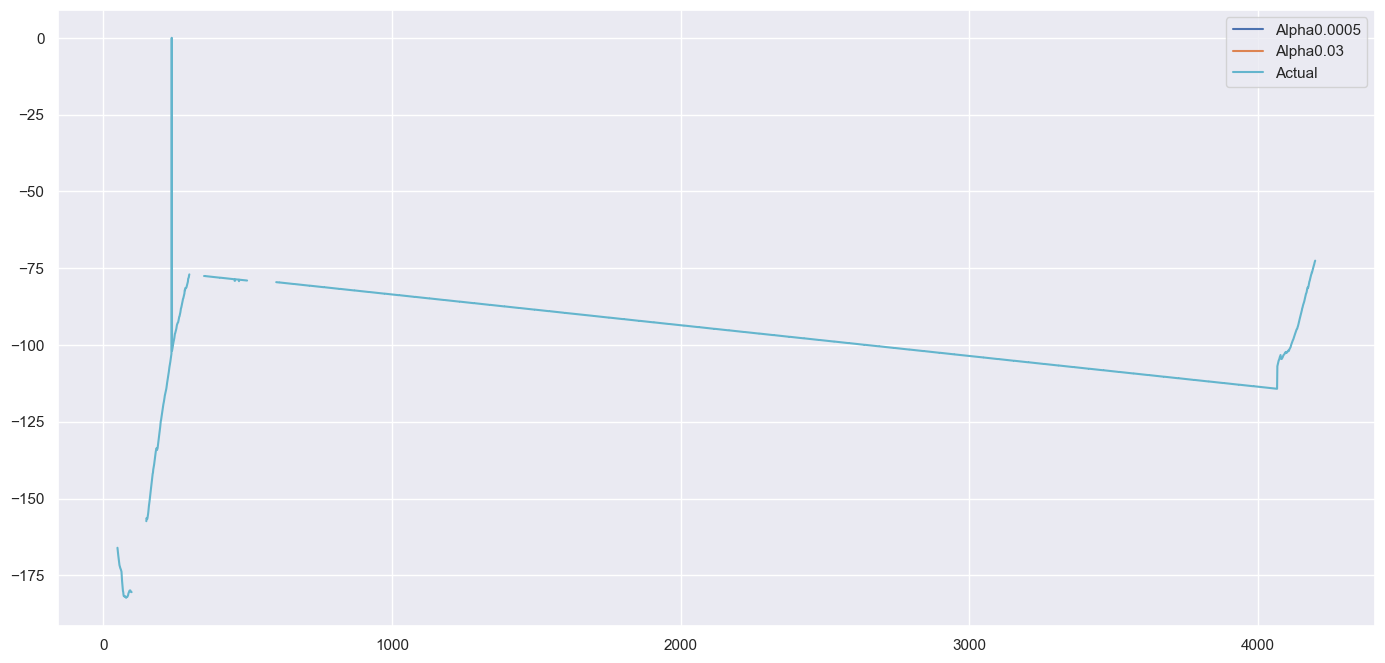

In [30]:
exponential_smoothing_plot(data.Flow_Rate_Lupa,[0.0005,0.03])

In [31]:
def double_exponential_smoothing(column,alpha,beta):
    result=[column[0]]
    
    for n in range(1, len(column)+1):
        if n==1:
            level,trend = column[0], column[1]-column[0]
            
        if n>=len(column):
            value = result[-1]
            
        else:
            value = column[n]
            
        last_level, level = level,alpha*value + (1-alpha)*(level+trend)
        trend = beta * (level-last_level) + (1-beta)*trend
        
        result.append(level+trend)
        
    return result

In [32]:
def double_exponential_smoothing_plot(column,alpha,beta):
    plt.figure(figsize=(17,8))
    for a in alpha:
        for b in beta:
            plt.plot(double_exponential_smoothing(column,a,b), label=f"Alpha {a}, Beta {b}")
        
    plt.plot(column.values,"c",label="Actual")
    plt.legend(loc="best")
    plt.grid(True)

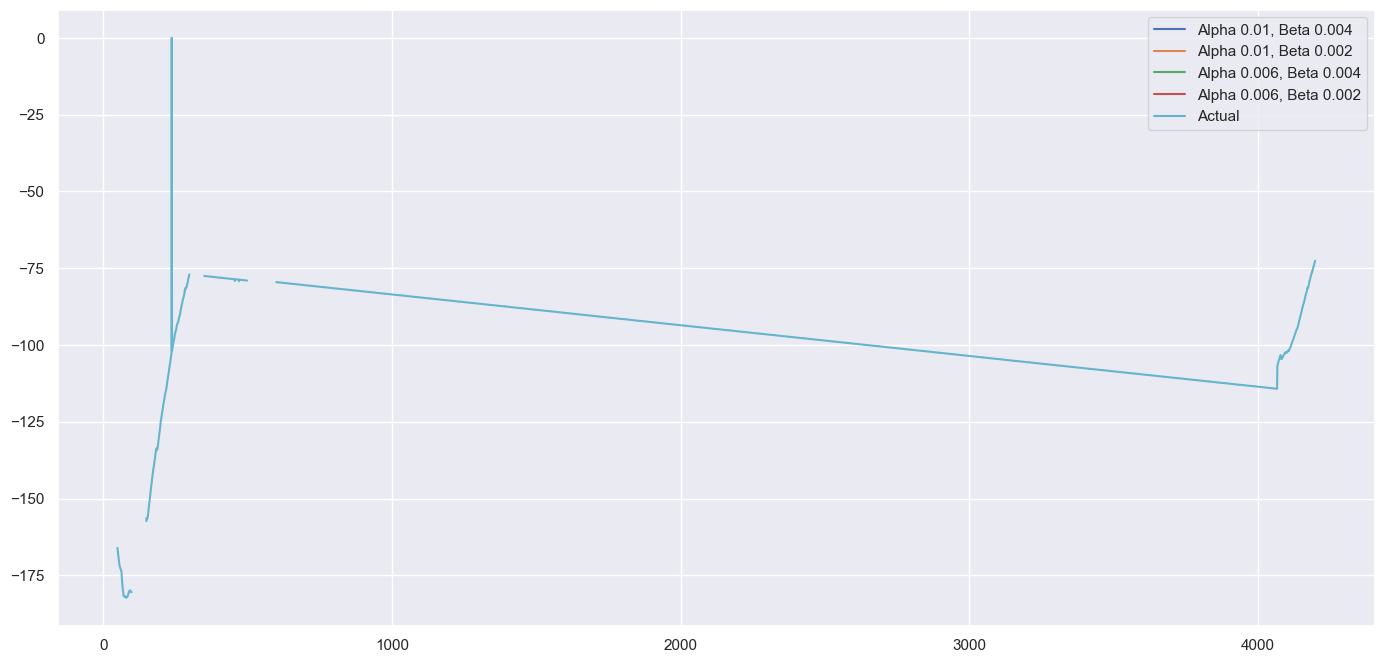

In [33]:
double_exponential_smoothing_plot(data.Flow_Rate_Lupa,alpha=[0.01,0.006], beta=[0.004,0.002])

In [34]:
#Dicky Fuller Test

def tsplot(y, lags=None, figsize=(15,8), style='bmh'):

    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout=(2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title("Dicky-Fuller: p={0:.5f}".format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

MissingDataError: exog contains inf or nans

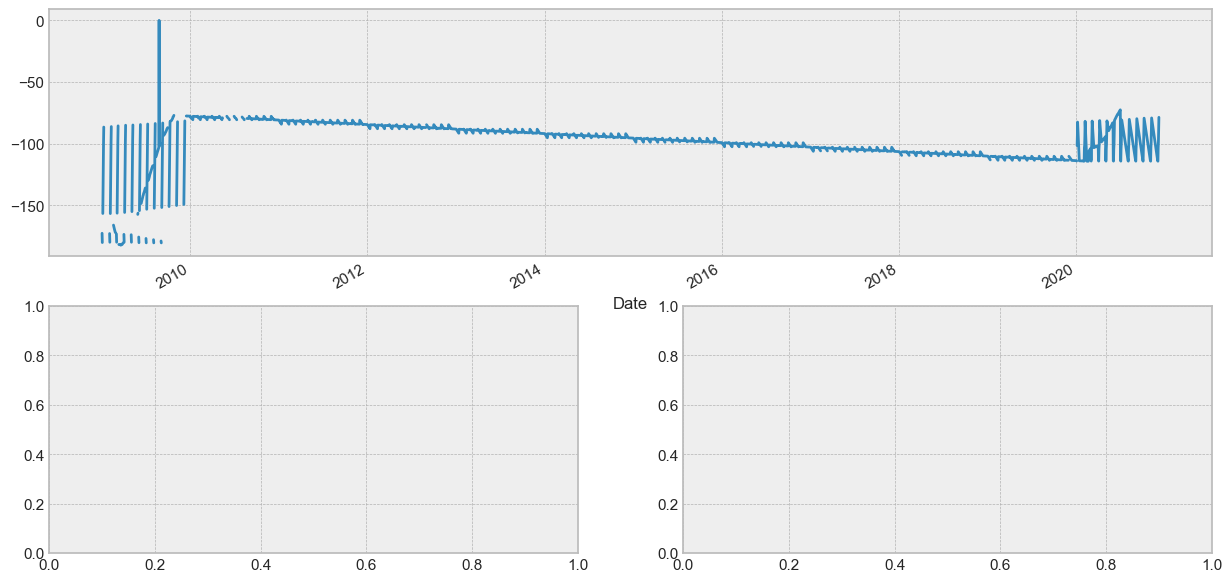

In [28]:
tsplot(data.Flow_Rate_Lupa, lags=40)

In [35]:
p = range(0,5)
d = 1
q = range(0,5)
P = range(0,5)
Q = range(0,5)
D = 1
s = 5

parameters= product(p,q,P,Q)
parameter_list = list(parameters)

In [36]:
len(parameter_list)

625

In [37]:
def SARIMA(parameter_list, d, D, s):
    results = []
    best_aic = float('inf')
    
    for p in parameter_list:
        model = sm.tsa.statespace.SARIMAX(data.Flow_Rate_Lupa, order=(p[0], d, p[1]), seasonal_order=(p[2],D,p[3],s)).fit()
        
        aic = model.aic
        
        if aic<best_aic:
            best_model = model
            best_aic = aic
            best_parameter = p
            
        results.append([p,model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ["Parameters", "AIC"]
    
    result_table = result_table.sort_values(by="AIC", ascending=True).reset_index(drop=True)
    return result_table